In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import time
from scipy.special import lambertw
import matplotlib as mpl
import os
import glob


from noise_distribution import sample_laplace_radius, sample_staircase_radius
from util import haversine_distance, initial_bearing, destination_point



In [2]:

# --- set global font to Times New Roman ---
# ---- Camera-ready settings (avoid Type-3 fonts) ----
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'

In [3]:
def planar_laplace_mechanism(lat, lon, epsilon, earth_radius=6_371_000):
    """
    Perturb a geographic point (lat, lon) with planar Laplace noise.
    
    Args:
      lat, lon       : original coordinates in decimal degrees
      epsilon        : privacy budget (>0)
      earth_radius   : in meters (default mean Earth radius)
    
    Returns:
      lat_p, lon_p   : perturbed coordinates in decimal degrees
    """
    # 1) sample radius & angle
    r     = sample_laplace_radius(epsilon)
    theta = np.random.uniform(0, 2*np.pi)
    
    # 2) convert original to local Cartesian (meters)
    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)
    
    # 3) add noise
    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)
    
    # 4) back to geo coords
    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    
    return lat_p, lon_p

In [4]:
# if __name__ == "__main__":
#     np.random.seed(42)
#     phi, lam = 40.7128, -74.0060   # e.g. New York City
#     eps = 0.01

#     lat_noisy, lon_noisy = planar_laplace_mechanism(phi, lam, eps)
#     print(f"Original: ({phi:.6f}, {lam:.6f})")
#     print(f"Noisy:    ({lat_noisy:.6f}, {lon_noisy:.6f})")


In [5]:


def planar_staircase_mechanism(lat, lon, epsilon, earth_radius=6_371_000):
    """
    Perturb a geographic point (lat, lon) with planar Laplace noise.
    
    Args:
      lat, lon       : original coordinates in decimal degrees
      epsilon        : privacy budget (>0)
      earth_radius   : in meters (default mean Earth radius)
    
    Returns:
      lat_p, lon_p   : perturbed coordinates in decimal degrees
    """
    # 1) sample radius & angle
    r     = sample_staircase_radius(epsilon, delta=1.0, L=None, size=1)
    theta = np.random.uniform(0, 2*np.pi)
    
    # 2) convert original to local Cartesian (meters)
    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)
    
    # 3) add noise
    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)
    
    # 4) back to geo coords
    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    
    return lat_p, lon_p

In [6]:
# # -----------------------------
# # Great-circle utilities for PSM-I
# # -----------------------------
# def haversine_distance(lat1, lon1, lat2, lon2, earth_radius=6_371_000):
#     """Vectorized distance in meters between (lat1, lon1) and (lat2, lon2)."""
#     φ1, φ2 = np.radians(lat1), np.radians(lat2)
#     Δφ = φ2 - φ1
#     Δλ = np.radians(lon2 - lon1)
#     a = np.sin(Δφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(Δλ/2)**2
#     return earth_radius * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# def initial_bearing(lat1, lon1, lat2, lon2):
#     """Bearing (radians) from (lat1,lon1) to (lat2,lon2) on a sphere."""
#     φ1 = np.radians(lat1)
#     φ2 = np.radians(lat2)
#     Δλ = np.radians(lon2 - lon1)
#     y = np.sin(Δλ) * np.cos(φ2)
#     x = np.cos(φ1) * np.sin(φ2) - np.sin(φ1) * np.cos(φ2) * np.cos(Δλ)
#     return np.arctan2(y, x)  # radians    


# def destination_point(lat1, lon1, distance_m, bearing_rad, earth_radius=6_371_000):
#     """Move from (lat1,lon1) by great-circle distance and bearing; returns (lat2,lon2) in degrees."""
#     φ1 = np.radians(lat1)
#     λ1 = np.radians(lon1)
#     δ  = distance_m / earth_radius
#     θ  = bearing_rad

#     sinφ2 = np.sin(φ1) * np.cos(δ) + np.cos(φ1) * np.sin(δ) * np.cos(θ)
#     φ2 = np.arcsin(np.clip(sinφ2, -1.0, 1.0))

#     y = np.sin(θ) * np.sin(δ) * np.cos(φ1)
#     x = np.cos(δ) - np.sin(φ1) * np.sin(φ2)
#     λ2 = λ1 + np.arctan2(y, x)

#     # normalize lon to [-pi, pi]
#     λ2 = (λ2 + np.pi) % (2*np.pi) - np.pi

#     return np.degrees(φ2), np.degrees(λ2)    

In [7]:
def bounded_planar_staircase_mechanism(lat, lon, epsilon, r_b, earth_radius=6_371_000, delta_step=1.0):
    """
    Bounded PSM: sample staircase radius truncated to L=r_b, then apply random angle in local plane.
    (Matches your sampler interface: sample_staircase_radius(eps, delta, L, size).)
    """
    r     = sample_staircase_radius(epsilon, delta=delta_step, L=r_b, size=1)  # <= r_b
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p


# -----------------------------
# PSM-I core
# -----------------------------
def apply_psmi_to_dataframe(df, epsilon, delta, r_b=50.0, earth_radius=6_371_000, use_noisy_threshold=True):
    """
    Apply PSM-I to a trajectory DataFrame with 'latitude' and 'longitude'.

    - y1 = bounded PSM(x1) within r_b
    - z1 = PSM(y1)
    - For t>=2: y_t = Move(y_{t-1}, Dis(x_{t-1},x_t), Dir(x_{t-1},x_t))
    - Selective reporting: refresh z_t only if Dis(y_ref, y_t) >= threshold
    - threshold is delta or noisy (delta + staircase noise) once per session
    """
    n = len(df)
    y_lat = np.zeros(n)
    y_lon = np.zeros(n)
    z_lat = np.zeros(n)
    z_lon = np.zeros(n)

    # ----- threshold (sample once per file/session) -----
    threshold = delta
    if use_noisy_threshold:
        # COMMENT OUT THE NEXT TWO LINES to make it "normal threshold" (i.e., threshold = delta)
        noise = sample_staircase_radius(epsilon, delta=delta_step, L=r_b, size=1)   # staircase radial sampler
        threshold = delta + noise

    # ----- init t=1 -----
    x1_lat, x1_lon = float(df.iloc[0]["latitude"]), float(df.iloc[0]["longitude"])

    y1_lat, y1_lon = bounded_planar_staircase_mechanism(x1_lat, x1_lon, epsilon, r_b, earth_radius)
    z1_lat, z1_lon = planar_staircase_mechanism(y1_lat, y1_lon, epsilon, earth_radius)

    y_lat[0], y_lon[0] = y1_lat, y1_lon
    z_lat[0], z_lon[0] = z1_lat, z1_lon

    y_ref_lat, y_ref_lon = y1_lat, y1_lon
    z_ref_lat, z_ref_lon = z1_lat, z1_lon

    # ----- main loop -----
    for t in range(1, n):
        x_prev_lat, x_prev_lon = float(df.iloc[t-1]["latitude"]), float(df.iloc[t-1]["longitude"])
        x_cur_lat,  x_cur_lon  = float(df.iloc[t]["latitude"]),   float(df.iloc[t]["longitude"])

        # displacement in true stream
        d_h = float(haversine_distance(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon, earth_radius))
        theta = float(initial_bearing(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon))

        # propagate intermediate by same displacement
        y_cur_lat, y_cur_lon = destination_point(y_lat[t-1], y_lon[t-1], d_h, theta, earth_radius)
        y_lat[t], y_lon[t] = y_cur_lat, y_cur_lon

        # selective reporting based on intermediate distance from last refresh
        d_y = float(haversine_distance(y_ref_lat, y_ref_lon, y_cur_lat, y_cur_lon, earth_radius))
        if d_y < threshold:
            # reuse last released
            z_lat[t], z_lon[t] = z_ref_lat, z_ref_lon
        else:
            # refresh
            z_new_lat, z_new_lon = planar_staircase_mechanism(y_cur_lat, y_cur_lon, epsilon, earth_radius)
            z_lat[t], z_lon[t] = z_new_lat, z_new_lon
            y_ref_lat, y_ref_lon = y_cur_lat, y_cur_lon
            z_ref_lat, z_ref_lon = z_new_lat, z_new_lon

    # true-to-released distances (utility)
    distances = haversine_distance(
        df["latitude"].values, df["longitude"].values,
        z_lat, z_lon,
        earth_radius
    )
    return y_lat, y_lon, z_lat, z_lon, distances


In [8]:
# -----------------------------
# Unified batch function (TR-PSM -> PSM-I)
# -----------------------------
def batch_perturb_csv(input_folder, output_folder, mechanism="psm", epsilon=0.5, delta=5.0, r_b=50.0, use_noisy_threshold=True):
    """
    Perturb all CSVs in `input_folder` and save results in `output_folder`.

    mechanism: "psm", "plm", or "psmi"
    epsilon: privacy budget
    delta: base threshold for PSM-I selective reporting
    r_b: bounding radius for y1 initialization
    use_noisy_threshold: if False, threshold = delta (no privatization)
    """
    os.makedirs(output_folder, exist_ok=True)

    if mechanism == "psm":
        mech_fn = planar_staircase_mechanism
    elif mechanism == "plm":
        mech_fn = planar_laplace_mechanism

    for filepath in glob.glob(os.path.join(input_folder, "*.csv")):
        df = pd.read_csv(filepath)

        if not {"latitude", "longitude"}.issubset(df.columns):
            print(f"Skipping {filepath}: missing latitude/longitude")
            continue

        if mechanism in ("psm", "plm"):
            perturb = df.apply(
                lambda row: mech_fn(row["latitude"], row["longitude"], epsilon),
                axis=1, result_type="expand"
            )
            perturb.columns = ["perturbed_latitude", "perturbed_longitude"]
            df = pd.concat([df, perturb], axis=1)

            df["distance"] = haversine_distance(
                df["latitude"].values, df["longitude"].values,
                df["perturbed_latitude"].values, df["perturbed_longitude"].values
            )

        elif mechanism == "psmi":
            y_lat, y_lon, z_lat, z_lon, distances = apply_psmi_to_dataframe(
                df, epsilon=epsilon, delta=delta, r_b=r_b, use_noisy_threshold=use_noisy_threshold
            )
            df["intermediate_latitude"]  = y_lat
            df["intermediate_longitude"] = y_lon
            df["perturbed_latitude"]     = z_lat
            df["perturbed_longitude"]    = z_lon
            df["distance"]               = distances

        out_path = os.path.join(output_folder, os.path.basename(filepath))
        df.to_csv(out_path, index=False)


In [9]:
epsilons = [0.1, 0.2, 0.5, 1, 2]
input_folder = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\original\geotrace\utility"

base_dirs = {
    "psm":  r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\utility\psm",
    "plm":  r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\utility\plm",
    "psmi": r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\utility\psmi"
}

for mechanism, base_out in base_dirs.items():
    for eps in epsilons:
        suffix = f"eps{int(eps*10):02d}" if eps < 1 else f"eps{int(eps)}"
        out_folder = os.path.join(base_out, suffix)
        print(f"> {mechanism.upper()}  ε={eps} → {out_folder}")

        batch_perturb_csv(
            input_folder=input_folder,
            output_folder=out_folder,
            mechanism=mechanism,
            epsilon=eps,
            delta=5.0,
            r_b=50.0,                 # <-- set this how you want
            use_noisy_threshold=False  # <-- set False OR comment the noise lines above
        )

> PSM  ε=0.1 → C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\utility\psm\eps01
> PLM  ε=0.1 → C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\utility\plm\eps01
> PSMI  ε=0.1 → C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\utility\psmi\eps01


epsilons : [0.1]
PLM mean : [17.967349789171497]
PSM mean : [8.798452771727433]
PSM-I mean: [13.45631448725386]


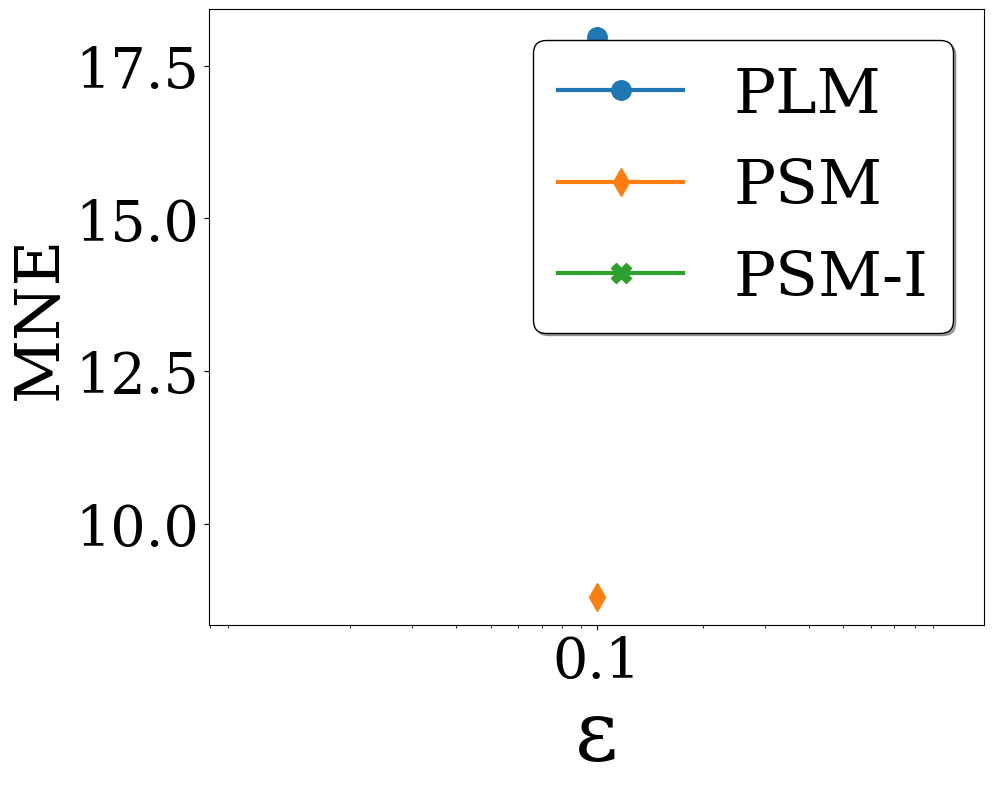

In [12]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# List of ε values
epsilons = [0.1]

# Base folders
psm_base  = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\utility\psm"
plm_base  = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\utility\plm"
psmi_base = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\data\distorted\geotrace\utility\psmi"  # <-- rename this

def eps_suffix(eps: float) -> str:
    return f"eps{int(eps*10):02d}" if eps < 1 else f"eps{int(eps)}"

def mean_distance_in_folder(folder: str) -> float:
    """
    Returns mean of per-file mean distances inside folder/*.csv.
    If folder missing or no valid files, returns NaN.
    """
    if not os.path.isdir(folder):
        print(f"[WARN] Missing folder: {folder}")
        return float("nan")

    files = glob.glob(os.path.join(folder, "*.csv"))
    if not files:
        print(f"[WARN] No CSV files in: {folder}")
        return float("nan")

    per_file_means = []
    for f in files:
        try:
            df = pd.read_csv(f)
            if "distance" not in df.columns:
                print(f"[WARN] 'distance' column missing in: {f}")
                continue
            if len(df["distance"]) == 0:
                continue
            per_file_means.append(df["distance"].mean())
        except Exception as e:
            print(f"[WARN] Failed reading {f}: {e}")

    if not per_file_means:
        print(f"[WARN] No valid distance values in: {folder}")
        return float("nan")

    return float(np.mean(per_file_means))

# Compute mean distance per ε for each mechanism
mean_psm  = []
mean_plm  = []
mean_psmi = []

for eps in epsilons:
    suffix = eps_suffix(eps)

    folder_psm  = os.path.join(psm_base, suffix)
    folder_plm  = os.path.join(plm_base, suffix)
    folder_psmi = os.path.join(psmi_base, suffix)

    mean_psm.append(mean_distance_in_folder(folder_psm))
    mean_plm.append(mean_distance_in_folder(folder_plm))
    mean_psmi.append(mean_distance_in_folder(folder_psmi))

print("epsilons :", epsilons)
print("PLM mean :", mean_plm)
print("PSM mean :", mean_psm)
print("PSM-I mean:", mean_psmi)

# ---- Plot ----
FIGSIZE = (10, 8)
plt.figure(figsize=FIGSIZE)

plot_attrs = [
    {'label': r'PLM',   'color': '#1F77B4', 'marker': 'o'},
    {'label': r'PSM',   'color': '#FF7F0E', 'marker': 'd'},
    {'label': r'PSM-I', 'color': '#2CA02C', 'marker': 'X'}
]

for attrs, values in zip(plot_attrs, [mean_plm, mean_psm, mean_psmi]):
    plt.plot(
        epsilons,
        values,
        label=attrs['label'],
        color=attrs['color'],
        marker=attrs['marker'],
        linestyle='solid',
        linewidth=3,
        markersize=14
    )

plt.xlabel('ε', fontsize=60)

plt.ylabel('MNE', fontsize=45)
plt.xscale('log')
plt.xticks(epsilons, labels=[str(e) for e in epsilons])
plt.tick_params(axis='both', which='major', labelsize=40)

legend = plt.legend(fontsize=45, frameon=True, shadow=True)
legend.get_frame().set_edgecolor('black')

# ---- Save as PDF ----
output_dir = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\figures"
os.makedirs(output_dir, exist_ok=True)
pdf_path = os.path.join(output_dir, "geotrace_psmi_distance_vs_epsilon.pdf")
plt.savefig(pdf_path, format='pdf', bbox_inches='tight')

plt.show()
